In [167]:
import math
import numpy as np
import json
from datetime import datetime, timedelta

def calculate_maximum_water_pressure(Ta):
    return 611.21 * np.exp(17.502 * Ta / (240.97 + Ta))

def calculate_actual_water_pressure(Td):
    return 611.21 * np.exp(17.502 * Td / (240.97 + Td))

def calculate_relative_humidity(Td, Ta):
    max_water_pressure = calculate_maximum_water_pressure(Ta)
    actual_water_pressure = calculate_actual_water_pressure(Td)
    return 100*actual_water_pressure / max_water_pressure

# Example usage:
Ta = 25  # Replace with the actual air temperature (in degrees Celsius)
Td = 20  # Replace with the actual dew point temperature (in degrees Celsius)

max_pressure = calculate_maximum_water_pressure(Ta)
actual_pressure = calculate_actual_water_pressure(Td)
humidity = calculate_relative_humidity(Td, Ta)

print(f"Maximum Water Pressure: {max_pressure} Pa")
print(f"Actual Water Pressure: {actual_pressure} Pa")
print(f"Relative Humidity: {humidity}%")


Maximum Water Pressure: 3167.0345307107345 Pa
Actual Water Pressure: 2337.282472851255 Pa
Relative Humidity: 73.80034698664086%


In [166]:
def extract_weather_data(file_path, lat, lon, start_date):
    # Open the netCDF file
    dataset = xr.open_dataset(file_path)
    
    # Select the specific location and time using nearest extrapolation
    data = dataset.sel(latitude=lat, longitude=lon, time=slice(start_date, None), method='nearest')

    # Extract the temperature and dew point data
    temperature = data['t2m']
    dew_point = data['d2m']
    
    return temperature, dew_point

In [88]:
lat

45.5

In [183]:
def get_threats(ds,lat,lon,time_start,disease):
    data = ds.sel(latitude=lat, longitude=lon,method = 'nearest')
    date_format = "%Y-%m-%d"
    
    dewpoint = data.sel(time=slice(time_start, datetime.strptime(time_start,date_format) + timedelta(days=10)))['d2m'].values.flatten()-273.15
    temp = data.sel(time=slice(time_start, datetime.strptime(time_start, date_format) + timedelta(days=10)))['t2m'].values.flatten()-273.15
    time = data.sel(time=slice(time_start, datetime.strptime(time_start, date_format) + timedelta(days=10)))['time'].values
    spec_humidity = calculate_relative_humidity(dewpoint+273.15,temp+273.15)
    threat_level = []
# Check for onset threat levels
    for current_temperature,current_humidity in zip(temp,spec_humidity):
        threats = check_progression_threat(current_temperature, current_humidity)
        indicator = threats[threats['Codename']==disease]['Progression Threat Level'].values
        threat_level.append(indicator)

    #print(threat_level)
    threat_level = pd.DataFrame({'Threat':threat_level}).rolling(3).mean()
    threat_level['Time'] = time
    threat_level['Time'] = threat_level['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    # Convert dataframe "df" to dictionary
    df_dict = threat_level.dropna(inplace = False).to_dict()
    df_dict['disease'] = disease
    df_dict['lat'] = lat
    df_dict['lon'] = lon

#Store the dictionary into a json string variable in memory
    df_json = json.dumps(df_dict)

    return df_json

In [182]:
(get_threats(ds,lat,lon,'2021-08-13','mild'))

'{"Threat": {"2": 1.0, "3": 1.0, "4": 1.0, "5": 1.0, "6": 1.0, "7": 0.6666666666666666, "8": 0.3333333333333333, "9": 0.3333333333333333, "10": 0.6666666666666666, "11": 1.0, "12": 1.0, "13": 1.0, "14": 1.0, "15": 1.0, "16": 1.0, "17": 1.0, "18": 0.6666666666666666, "19": 0.3333333333333333, "20": 0.0, "21": 0.3333333333333333, "22": 0.3333333333333333, "23": 0.3333333333333333, "24": 0.0, "25": 0.0, "26": 0.3333333333333333, "27": 0.6666666666666666, "28": 1.0, "29": 1.0, "30": 1.0, "31": 1.0, "32": 1.0, "33": 1.0, "34": 1.0, "35": 1.0, "36": 1.0, "37": 1.0, "38": 0.6666666666666666, "39": 0.3333333333333333, "40": 0.3333333333333333}, "Time": {"2": "2021-08-13 12:00:00", "3": "2021-08-13 18:00:00", "4": "2021-08-14 00:00:00", "5": "2021-08-14 06:00:00", "6": "2021-08-14 12:00:00", "7": "2021-08-14 18:00:00", "8": "2021-08-15 00:00:00", "9": "2021-08-15 06:00:00", "10": "2021-08-15 12:00:00", "11": "2021-08-15 18:00:00", "12": "2021-08-16 00:00:00", "13": "2021-08-16 06:00:00", "14": 

In [143]:
import pandas as pd

# Define the disease conditions in a DataFrame
disease_conditions = pd.DataFrame({
    'Disease': ['Downy Mildew', 'Powdery Mildew', 'Anthracnose', 'Gray Mold (Botrytis cinerea)', 'Black Spot', 'Black Rot', 'White Rot', 'Verticillium Wilt', 'Alternaria Leaf Spot', 'Fusarium Wilt', 'Red Blotch (Esca)', 'Bacterial Cancer'],
    'Codename':['mild','oidium','anthra','gray','blackDots','black','white','vilt','alternarioz','fuzarioz','krasnuha','bakterial'],
    'Temperature Onset': [11, 5, (10, 15), 12, 15, '-', 14, '-', (11, 15), 1, 11, '-'],
    'Humidity Onset': [(85, 100), (60, 80), (70, 80), (95, 100), (80, 90), '-', (90, 100), '-', (80, 90), (40, 80), (80, 90), '-'],
    'Optimal Temperature': [(21, 25), (20, 35), (24, 30), (25, 30), (18, 20), (20, 25), (20, 27), (21, 24), (23, 25), (13, 20), (18, 20), (25, 30)],
    'Optimal Humidity': [(93,100), (60, 80), (70, 80), (90,100), (80, 90), (90,100), (90, 100), (50, 60), (80, 90), (80, 90), '-', (95, 100)]
})
print(disease_conditions)
def check_range(value, range_value):
    if isinstance(range_value, tuple):
        return range_value[0] <= value <= range_value[1]
    elif range_value == '-':
        return True
    else:
        return value >= range_value - 2 and value <= range_value + 2

def check_onset_threat(temperature, humidity):
    onset_threat_levels = {}
    
    for _, disease in disease_conditions.iterrows():
        temp_onset = check_range(temperature, disease['Temperature Onset'])
        humi_onset = check_range(humidity, disease['Humidity Onset'])
        
        threat_level = temp_onset and humi_onset
        progression_threat_levels[disease['Codename']] = 1.0 if threat_level else 0.0
        
    return pd.DataFrame(list(onset_threat_levels.items()), columns=['Codename', 'Onset Threat Level'])

def check_progression_threat(temperature, humidity):
    progression_threat_levels = {}
    
    for _, disease in disease_conditions.iterrows():
        temp_optimal = check_range(temperature, disease['Optimal Temperature'])
        humi_optimal = check_range(humidity, disease['Optimal Humidity'])
        
        threat_level = temp_optimal and humi_optimal
        progression_threat_levels[disease['Codename']] = 1.0 if threat_level else 0.0
        
    return pd.DataFrame(list(progression_threat_levels.items()), columns=['Codename', 'Progression Threat Level'])

# Example usage:

    
# Check for progression threat levels
#progression_threats = check_progression_threat(current_temperature, current_humidity)
#print(progression_threats)


                         Disease     Codename Temperature Onset  \
0                   Downy Mildew         mild                11   
1                 Powdery Mildew       oidium                 5   
2                    Anthracnose       anthra          (10, 15)   
3   Gray Mold (Botrytis cinerea)         gray                12   
4                     Black Spot    blackDots                15   
5                      Black Rot        black                 -   
6                      White Rot        white                14   
7              Verticillium Wilt         vilt                 -   
8           Alternaria Leaf Spot  alternarioz          (11, 15)   
9                  Fusarium Wilt     fuzarioz                 1   
10             Red Blotch (Esca)     krasnuha                11   
11              Bacterial Cancer    bakterial                 -   

   Humidity Onset Optimal Temperature Optimal Humidity  
0       (85, 100)            (21, 25)        (93, 100)  
1        (60, 

In [86]:
threat_level.to_json('threat.json')

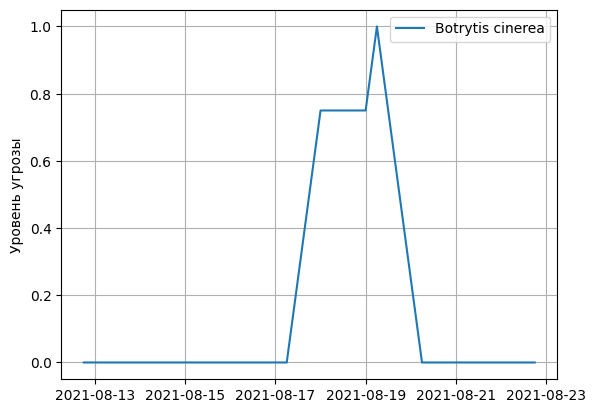

In [84]:
plt.plot(threat_level['time'],threat_level[0])
plt.ylabel('Уровень угрозы')
plt.legend(['Botrytis cinerea'])
plt.grid('on')